(first)=

# Getting started

This tutorial is based on [the quickstart example in the celerite documentation](https://celerite.readthedocs.io/en/stable/tutorials/first/), but it has been updated to work with *celerite2*.

For this tutorial, we’re going to fit a Gaussian Process (GP) model to a simulated dataset with quasiperiodic oscillations.
We’re also going to leave a gap in the simulated data and we’ll use the GP model to predict what we would have observed for those "missing" datapoints.

To start, here’s some code to simulate the dataset:

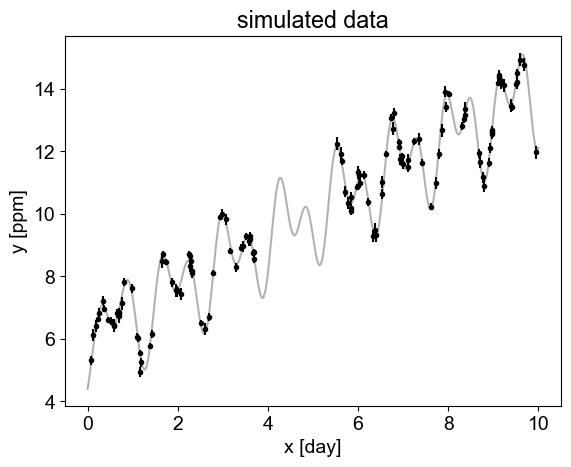

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Arial'

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 57),
        np.random.uniform(5.5, 10, 68),
    )
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t)) #均匀分布
y = abs(
    0.2 * (t - 5)
    - 1 * (t + 5)
    + np.sin(10 * t + 0.1 * (t - 5) ** 2)
    + np.cos(5*t)
    + yerr * np.random.randn(len(t))

)

true_t = np.linspace(0, 10, 500)
true_y = abs(0.2 * (true_t - 5) - 1*(true_t+5) + \
        np.sin(10 * true_t + 0.1 * (true_t - 5) ** 2)+\
        np.cos(5*true_t)
        )

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

plt.show()

Now, let's fit this dataset using a mixture of `SHOTerm` terms: one quasi-periodic component and one non-periodic component.
First let's set up an initial model to see how it looks:

In [29]:
import celerite2
from celerite2 import terms

sigma = np.std(y)
rho = 2
# tau = 20
print(f'initial sigma: {sigma}')
print(f'initial rho: {rho}')
# print(f'initial tau: {tau}')

# Quasi-periodic term
term1 = terms.SHOTerm(sigma=sigma, w0=2*np.pi*(1/rho), Q=2) #sigma是process的标准差, rho是周期(这里是主周期), tau表征震荡时间, 可以大一点

# Non-periodic component
term2 = terms.SHOTerm(sigma=sigma, w0=2*np.pi*(1/(rho*5)), Q=0.25)
kernel = term1 + term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(t, yerr=yerr)

print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

initial sigma: 2.675279773540658
initial rho: 2
Initial log likelihood: -102.24565311367094


Let's look at the underlying power spectral density of this initial model:

In [30]:
gp.kernel.terms

(<celerite2.terms.SHOTerm at 0x11e86f700>,
 <celerite2.terms.SHOTerm at 0x11e86c7f0>)

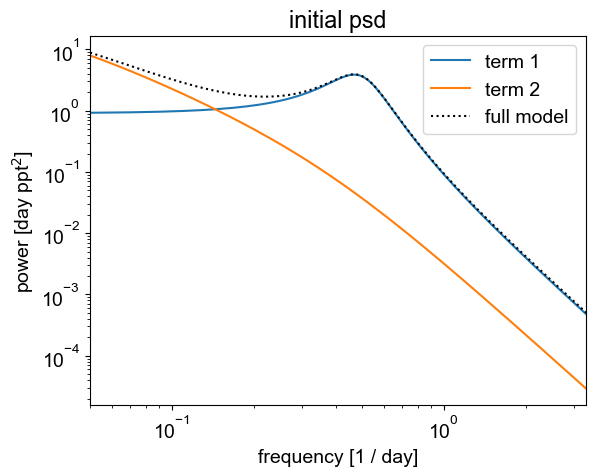

In [31]:
freq = np.linspace(1.0 / 20, 1.0 / 0.3, 500)
omega = 2 * np.pi * freq


def plot_psd(gp):
    for n, term in enumerate(gp.kernel.terms):
        plt.loglog(freq, term.get_psd(omega), label="term {0}".format(n + 1))
    plt.loglog(freq, gp.kernel.get_psd(omega), ":k", label="full model")
    plt.xlim(freq.min(), freq.max())
    plt.legend()
    plt.xlabel("frequency [1 / day]")
    plt.ylabel("power [day ppt$^2$]")


plt.title("initial psd")
plot_psd(gp)

And then we can also plot the prediction that this model makes for the missing data and compare it to the truth:

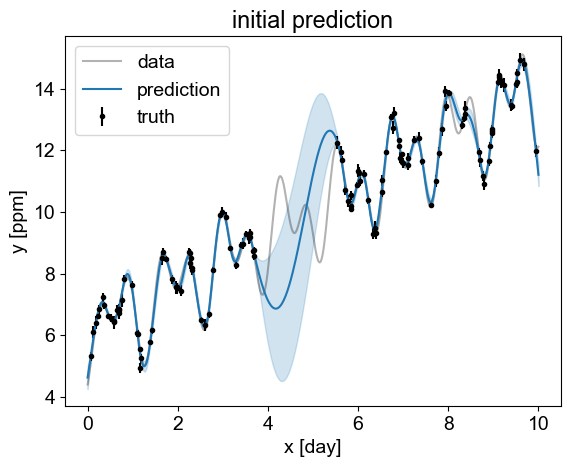

In [32]:
def plot_prediction(gp):
    plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="data")
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    if gp:
        mu, variance = gp.predict(y, t=true_t, return_var=True)
        sigma = np.sqrt(variance)
        plt.plot(true_t, mu, label="prediction")
        plt.fill_between(true_t, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
    # plt.xlim(0, 10)
    # plt.ylim(-2.5, 2.5)
    plt.legend()


plt.title("initial prediction")
plot_prediction(gp)

Ok, that looks pretty terrible, but we can get a better fit by numerically maximizing the likelihood as described in the following section.

## Maximum likelihood

In this section, we'll improve our initial GP model by maximizing the likelihood function for the parameters of the kernel, the mean, and a "jitter" (a constant variance term added to the diagonal of our covariance matrix).
To do this, we'll use the numerical optimization routine from [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html):

In [33]:
from scipy.optimize import minimize


def set_params(params, gp):
    gp.mean = params[0] #这一项可能代表均值函数部分, 因此为0
    theta = np.exp(params[1:])
    gp.kernel = terms.SHOTerm(
        sigma=theta[0], rho=theta[1], tau=theta[2] #一般的简谐振动核
    ) + terms.SHOTerm(sigma=theta[3], rho=theta[4], Q=0.25) #意味这是过阻尼简谐振动核
    gp.compute(t, diag=yerr**2 + theta[5], quiet=True) #这一步是为了计算协方差矩阵, 
    return gp


def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(y)


# 初始参数估计, 均值, sigma, rho, tau, second sigma, second rho, 噪声项, 注意np.exp(np.log(x))=x
initial_params = [0.0, np.log(4.0), 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
soln

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 45.719686275560235
        x: [ 9.537e+00 -4.173e-01 -4.675e-01  1.868e+00  1.162e+00
             1.558e+00 -1.429e+01]
      nit: 47
      jac: [-2.558e-05  9.379e-05  3.011e-03 -7.248e-05  4.846e-04
            -5.059e-04  8.242e-05]
     nfev: 448
     njev: 56
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

Now let's make the same plots for the maximum likelihood model:

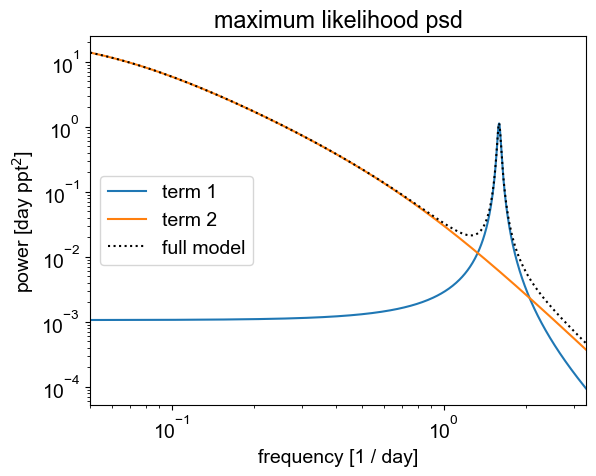

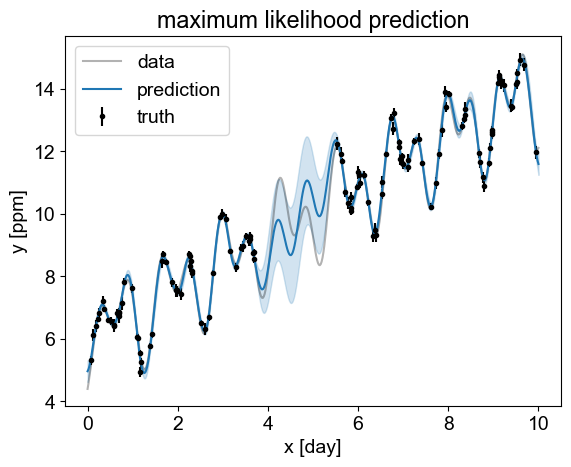

In [34]:
plt.figure()
plt.title("maximum likelihood psd")
plot_psd(opt_gp)

plt.figure()
plt.title("maximum likelihood prediction")
plot_prediction(opt_gp)

These predictions are starting to look much better!

## Posterior inference using emcee

Now, to get a sense for the uncertainties on our model, let's use Markov chain Monte Carlo (MCMC) to numerically estimate the posterior expectations of the model.
In this first example, we'll use the [emcee](https://emcee.readthedocs.io) package to run our MCMC.
Our likelihood function is the same as the one we used in the previous section, but we'll also choose a wide normal prior on each of our parameters.

In [35]:
soln.x

array([  9.53733332,  -0.41727751,  -0.46753365,   1.86833374,
         1.16221962,   1.55790866, -14.29273592])

In [36]:
import emcee

# 这里定义参数的先验分布, 这里是均匀分布
def log_prior(theta):
    x1, x2, x3, x4, x5, x6, x7 = theta
    if -10.0 < x1 < 0.5 and -10 < x2 < 10.0 and -10.0 < x3 < 10.0\
    and -10.0 < x4 < 10.0 and -10 < x5 < 10.0 and -10 < x6 < 10.0\
    and -20 < x7 < 10:
        return 0.0
    return -np.inf

def log_probability(theta, gp):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    # return (
    #     gp.log_likelihood(y) + lp,
    #     gp.kernel.get_psd(omega),
    # )
    return gp.log_likelihood(y)+lp


prior_sigma = 2

def log_prob(params, gp):
    gp = set_params(params, gp)
    return (
        gp.log_likelihood(y) - 0.5 * np.sum((params / prior_sigma) ** 2),
        gp.kernel.get_psd(omega),
    )


np.random.seed(5693854)
coords = soln.x + 1e-5 * np.random.randn(32, len(soln.x))
sampler = emcee.EnsembleSampler(
    coords.shape[0], coords.shape[1], log_prob, args=(gp,)
)
state = sampler.run_mcmc(coords, 2000, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, 5000, progress=True)

100%|██████████| 5000/5000 [00:17<00:00, 289.04it/s]


After running our MCMC, we can plot the predictions that the model makes for a handful of samples from the chain.
This gives a qualitative sense of the uncertainty in the predictions.

In [10]:
coords.shape

(32, 7)

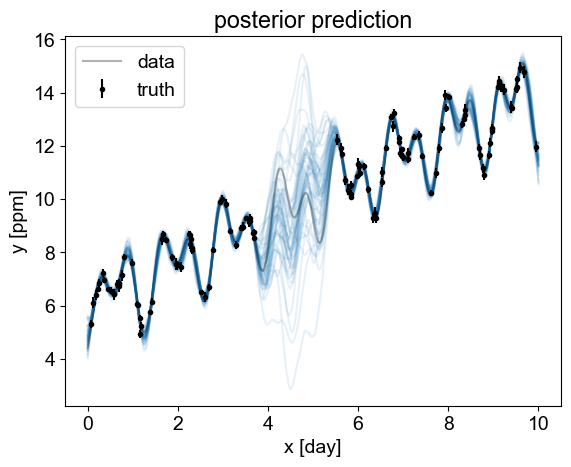

In [37]:
chain = sampler.get_chain(discard=100, flat=True)

# 采样之后画图
for sample in chain[np.random.randint(len(chain), size=50)]:
    gp = set_params(sample, gp) #分配参数
    conditional = gp.condition(y, true_t) #计算, 返回每一个t的对应y的中值
    plt.plot(true_t, conditional.sample(), color="C0", alpha=0.1)

plt.title("posterior prediction")
plot_prediction(None)

Similarly, we can plot the posterior expectation for the power spectral density:

In [12]:
chain.shape

(1596800, 7)

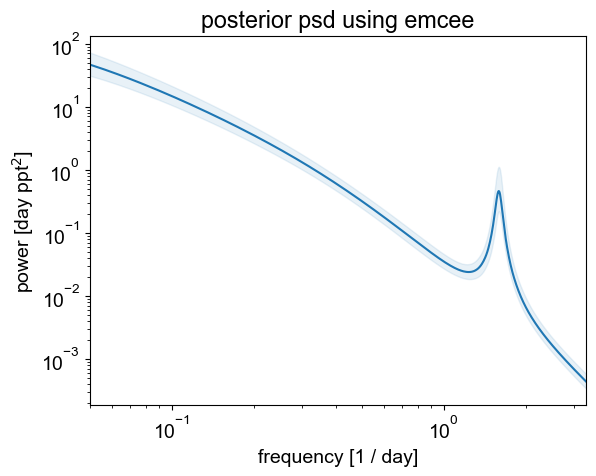

In [14]:
psds = sampler.get_blobs(discard=100, flat=True)

q = np.percentile(psds, [16, 50, 84], axis=0)

plt.loglog(freq, q[1], color="C0")
plt.fill_between(freq, q[0], q[2], color="C0", alpha=0.1)

plt.xlim(freq.min(), freq.max())
plt.xlabel("frequency [1 / day]")
plt.ylabel("power [day ppt$^2$]")
_ = plt.title("posterior psd using emcee")

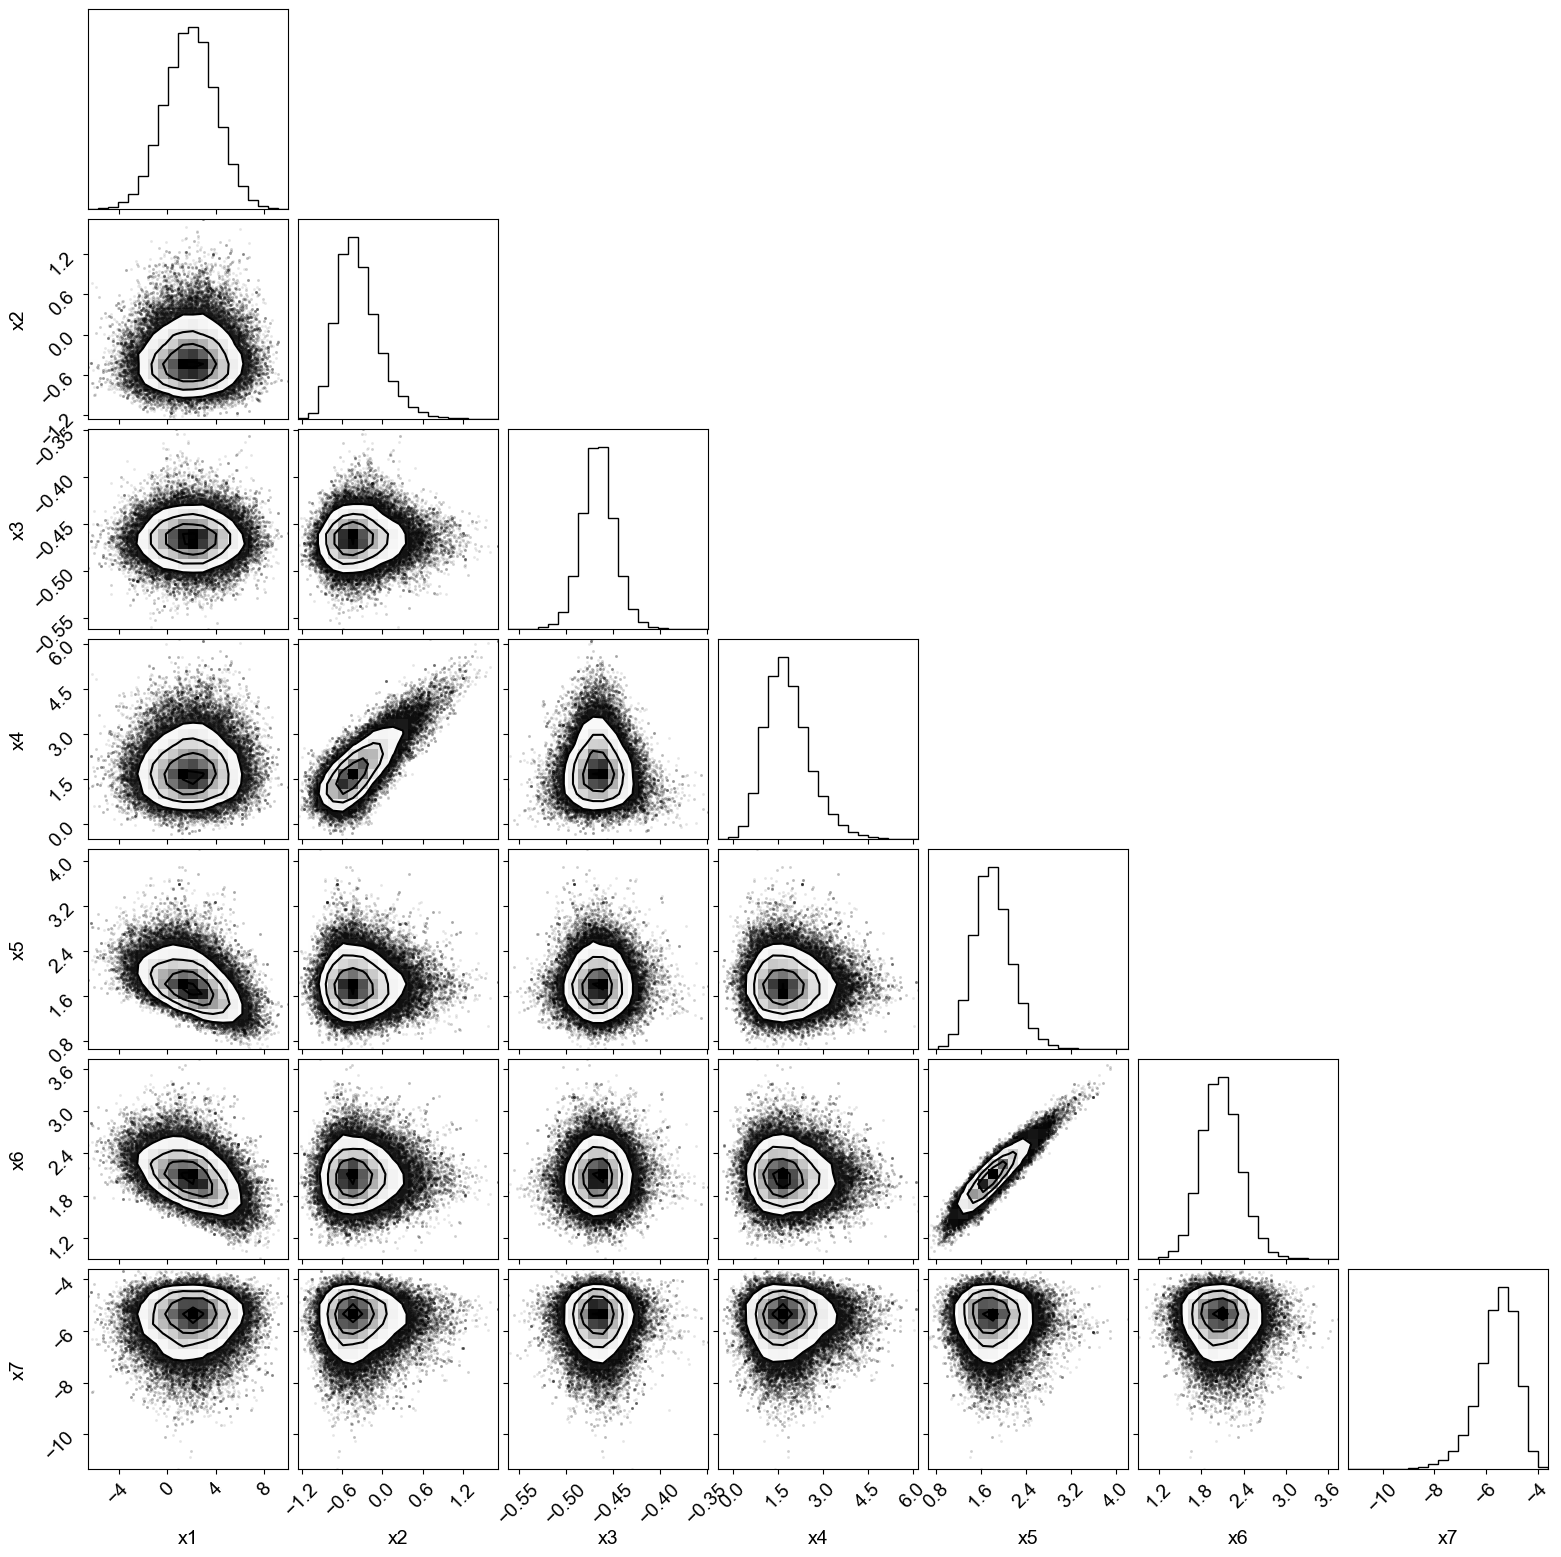

In [38]:
import corner

# 使用corner画图

fig = corner.corner(chain, labels=["x1", "x2", "x3", "x4", "x5",'x6','x7'])
plt.show()

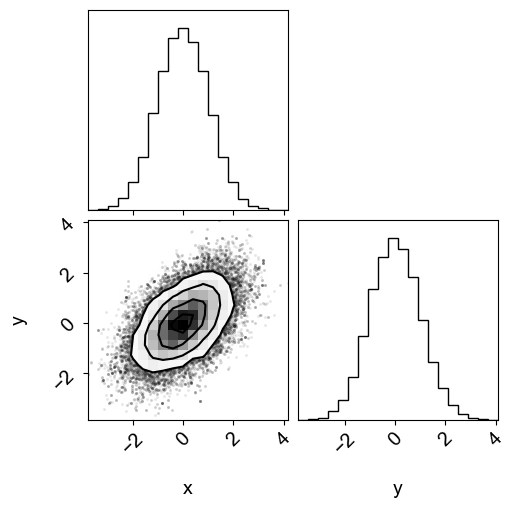

In [16]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

# 定义二元高斯分布的对数概率密度函数
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

# 目标分布的均值和协方差
mu = np.array([0.0, 0.0])
cov = np.array([[1.0, 0.5], [0.5, 1.0]])

# 初始化采样器
ndim = 2  # 参数的数量
nwalkers = 50  # 游走者的数量
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[mu, cov])

# 从高斯分布中随机初始化游走者的位置
p0 = np.random.randn(nwalkers, ndim)

# 运行MCMC采样
state = sampler.run_mcmc(p0, 1000)
samples = sampler.get_chain(flat=True)

# 使用corner画出采样参数的分布
figure = corner.corner(samples, labels=["x", "y"],
                       )

plt.show()


## Posterior inference using PyMC

*celerite2* also includes support for probabilistic modeling using PyMC (v5 or v3, using the `celerite2.pymc` or `celerite2.pymc3` submodule respectively), and we can implement the same model from above as follows:

In [24]:
pip show theano

Note: you may need to restart the kernel to use updated packages.


In [25]:
import pymc as pm

In [26]:
from celerite2.pymc import GaussianProcess, terms as pm_terms

In [27]:

# import theano
# theano.config.optimizer = 'None'

prior_sigma = 2

with pm.Model() as model:
    mean = pm.Normal("mean", mu=0.0, sigma=prior_sigma)
    log_jitter = pm.Normal("log_jitter", mu=0.0, sigma=prior_sigma)

    log_sigma1 = pm.Normal("log_sigma1", mu=0.0, sigma=prior_sigma)
    log_rho1 = pm.Normal("log_rho1", mu=0.0, sigma=prior_sigma)
    log_tau = pm.Normal("log_tau", mu=0.0, sigma=prior_sigma)
    term1 = pm_terms.SHOTerm(
        sigma=pm.math.exp(log_sigma1),
        rho=pm.math.exp(log_rho1),
        tau=pm.math.exp(log_tau),
    )

    log_sigma2 = pm.Normal("log_sigma2", mu=0.0, sigma=prior_sigma)
    log_rho2 = pm.Normal("log_rho2", mu=0.0, sigma=prior_sigma)
    term2 = pm_terms.SHOTerm(
        sigma=pm.math.exp(log_sigma2), rho=pm.math.exp(log_rho2), Q=0.25
    )

    kernel = term1 + term2
    gp = GaussianProcess(kernel, mean=mean)
    gp.compute(t, diag=yerr**2 + pm.math.exp(log_jitter), quiet=True)
    gp.marginal("obs", observed=y)

    pm.Deterministic("psd", kernel.get_psd(omega))

    trace = pm.sample(
        tune=1000,
        draws=1000,
        target_accept=0.9,
        init="adapt_full",
        cores=2,
        chains=2,
        random_seed=34923,
    )

ImportError: cannot import name 'supp_shape_from_ref_param_shape' from 'pytensor.tensor.random.utils' (/Users/xq/softwares/anaconda3/envs/pymc_env/lib/python3.10/site-packages/pytensor/tensor/random/utils.py)

Like before, we can plot the posterior estimate of the power spectrum to show that the results are qualitatively similar:

In [ ]:
psds = trace.posterior["psd"].values

q = np.percentile(psds, [16, 50, 84], axis=(0, 1))

plt.loglog(freq, q[1], color="C0")
plt.fill_between(freq, q[0], q[2], color="C0", alpha=0.1)

plt.xlim(freq.min(), freq.max())
plt.xlabel("frequency [1 / day]")
plt.ylabel("power [day ppt$^2$]")
_ = plt.title("posterior psd using PyMC")

## Posterior inference using numpyro

Since celerite2 also includes support for JAX, you can also use tools like [numpyro](https://github.com/pyro-ppl/numpyro) for inference.

In [ ]:
from jax.config import config

config.update("jax_enable_x64", True)

from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import celerite2.jax
from celerite2.jax import terms as jax_terms


def numpyro_model(t, yerr, y=None):
    mean = numpyro.sample("mean", dist.Normal(0.0, prior_sigma))
    log_jitter = numpyro.sample("log_jitter", dist.Normal(0.0, prior_sigma))

    log_sigma1 = numpyro.sample("log_sigma1", dist.Normal(0.0, prior_sigma))
    log_rho1 = numpyro.sample("log_rho1", dist.Normal(0.0, prior_sigma))
    log_tau = numpyro.sample("log_tau", dist.Normal(0.0, prior_sigma))
    term1 = jax_terms.SHOTerm(
        sigma=jnp.exp(log_sigma1), rho=jnp.exp(log_rho1), tau=jnp.exp(log_tau)
    )

    log_sigma2 = numpyro.sample("log_sigma2", dist.Normal(0.0, prior_sigma))
    log_rho2 = numpyro.sample("log_rho2", dist.Normal(0.0, prior_sigma))
    term2 = jax_terms.SHOTerm(
        sigma=jnp.exp(log_sigma2), rho=jnp.exp(log_rho2), Q=0.25
    )

    kernel = term1 + term2
    gp = celerite2.jax.GaussianProcess(kernel, mean=mean)
    gp.compute(t, diag=yerr**2 + jnp.exp(log_jitter), check_sorted=False)

    numpyro.sample("obs", gp.numpyro_dist(), obs=y)
    numpyro.deterministic("psd", kernel.get_psd(omega))


nuts_kernel = NUTS(numpyro_model, dense_mass=True)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    progress_bar=False,
)
rng_key = random.PRNGKey(34923)
%time mcmc.run(rng_key, t, yerr, y=y)

This runtime was similar to the PyMC result from above, and (as we'll see below) the convergence is also similar.
Any difference in runtime will probably disappear for more computationally expensive models, but this interface is looking pretty great here!

As above, we can plot the posterior expectations for the power spectrum:

In [ ]:
psds = np.asarray(mcmc.get_samples()["psd"])

q = np.percentile(psds, [16, 50, 84], axis=0)

plt.loglog(freq, q[1], color="C0")
plt.fill_between(freq, q[0], q[2], color="C0", alpha=0.1)

plt.xlim(freq.min(), freq.max())
plt.xlabel("frequency [1 / day]")
plt.ylabel("power [day ppt$^2$]")
_ = plt.title("posterior psd using numpyro")

## Comparison

Finally, let's compare the results of these different inference methods a bit more quantitaively.
First, let's look at the posterior constraint on the period of the underdamped harmonic oscillator, the effective period of the oscillatory signal.

In [ ]:
import arviz as az

emcee_data = az.from_emcee(
    sampler,
    var_names=[
        "mean",
        "log_sigma1",
        "log_rho1",
        "log_tau",
        "log_sigma2",
        "log_rho2",
        "log_jitter",
    ],
)

pm_data = trace
numpyro_data = az.from_numpyro(mcmc)

bins = np.linspace(1.5, 2.75, 25)
plt.hist(
    np.exp(np.asarray((emcee_data.posterior["log_rho1"].T)).flatten()),
    bins,
    histtype="step",
    density=True,
    label="emcee",
)
plt.hist(
    np.exp(np.asarray((pm_data.posterior["log_rho1"].T)).flatten()),
    bins,
    histtype="step",
    density=True,
    label="PyMC",
)
plt.hist(
    np.exp(np.asarray((numpyro_data.posterior["log_rho1"].T)).flatten()),
    bins,
    histtype="step",
    density=True,
    label="numpyro",
)
plt.legend()
plt.yticks([])
plt.xlabel(r"$\rho_1$")
_ = plt.ylabel(r"$p(\rho_1)$")

That looks pretty consistent.

Next we can look at the [ArviZ](https://arviz-devs.github.io/arviz/) summary for each method to see how the posterior expectations and convergence diagnostics look.

In [ ]:
az.summary(
    emcee_data,
    var_names=[
        "mean",
        "log_sigma1",
        "log_rho1",
        "log_tau",
        "log_sigma2",
        "log_rho2",
        "log_jitter",
    ],
)

In [ ]:
az.summary(
    pm_data,
    var_names=[
        "mean",
        "log_sigma1",
        "log_rho1",
        "log_tau",
        "log_sigma2",
        "log_rho2",
        "log_jitter",
    ],
)

In [ ]:
az.summary(
    numpyro_data,
    var_names=[
        "mean",
        "log_sigma1",
        "log_rho1",
        "log_tau",
        "log_sigma2",
        "log_rho2",
        "log_jitter",
    ],
)

Overall these results are consistent, but the $\hat{R}$ values are a bit high for the emcee run, so I'd probably run that for longer.
Either way, for models like these, PyMC and numpyro are generally going to be much better inference tools (in terms of runtime per effective sample) than emcee, so those are the recommended interfaces if the rest of your model can be easily implemented in such a framework.